# Sequence to Sequence with Attention

## Seq2Seq with attention

### Seq2Seq Model
* many-to-many RNN 구조에 해당함
* input sequence를 모두 읽은 후 output sequence를 예측하는 model
  * input : word 단위의 문장
  * output : word 단위의 문장

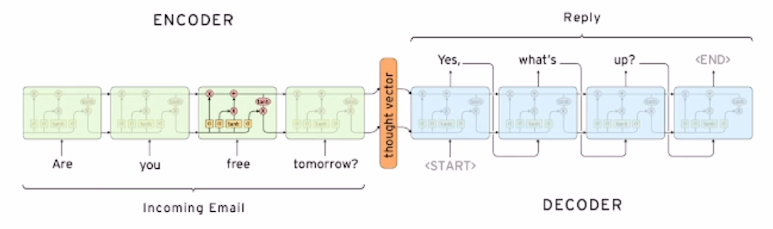

* Encoder : 입력 문장을 읽어들이는 부분, parameter로 이루어진 RNN model
  * LSTM 사용함
* Decoder : 출력 문장을 단어 하나씩 생성하는 부분, parameter로 이루어진 RNN model
* Encoder의 마지막 timestep의 hidden-state vector는 Decoder의 첫 번째 timestep에 입력으로 주어지는 이전 timestep의 hidden-state vector
  * Encoder에서의 정보를 바탕으로 Decoder에서 그에 대응하는 단어를 예측함
* <SoS> : Start of Sentence token
  * start token
  * word별로 문장을 생성하는 task에서 첫 번째 input 단어를 지칭함
  * Vocabulary에 정의하고, 첫 decode step에 넣어서 생성되는 첫 번째 단어부터 예측함
* <EOS> : End of Sentence token
  * 마지막 생성 단어
  * <EOS> token이 나올 때까지 Decoder를 구동하고, <EOS> token이 나오면 더이상 단어를 생성하지 않음


### Seq2Seq Model with Attention
* sequence의 길이와 상관없이 hidden-state vector의 dimension이 정해져있기 때문에, encoder의 마지막 timestep에서 hidden-state vector는 많은 정보들을 압축하고 있어야 함
* long-term dependency를 해결하였어도, 마지막 timestep을 기준으로 훨씬 이전에 나타났던 단어에 대한 정보는 변질되거나 소실될 수 있음
  * 앞 쪽의 정보를 잘 저장하지 못하는 현상이 발생함

* Attention module의 기본적인 아이디어
  * 마지막 timestep의 hidden-state vector에만 의존하는 것이 아니라, 각 단어를 encoding하는 과정에서 나오는 모든 hidden-state vector(해당 timestep에 들어온 단어를 주된 정보로 가짐, $h_t^{(e)}$)들을 decoder에 제공하고, decoder에서는 각 timestep에서 필요로 하는 encoder hidden-state vector를 선별적으로 가져가서 예측에 도움을 주는 형태

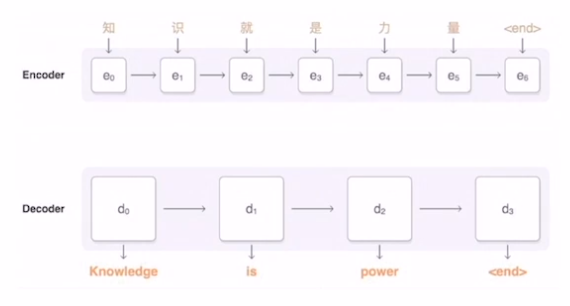

## Encoder-decoder architecture, Attention mechanism

* Attention Module이 동작하는 과정
  * 프랑스어를 영어로 번역
    * hidden-state vector dimension : 4
    * 각 단어를 예측할 때 decoder hidden-state vector와 해당하는 정보를 가진 encoder hidden-state vector를 내적 연산을 함 : 내적에 기반한 유사도 => Attention scores
    * 내적 값을 **softmax**를 통과시 각각의 hidden-state vector에 대응하는 확률값을 계산함 => Attention distribution
    * 이 확률값은 encoder hidden-state vector에 부여되는 가중치로 사용됨 => attention vector
    * encoder hidden-state vector에 대해 가중치 set를 적용하여 가중평균을 구하고, 가중평균으로 나오는 하나의 encoding vector를 구함 => context vector

* Attention Module
  * input : decoder hidden-state vector, encoder hidden-state vector set
  * output : context vector(encoder hidden-state vector의 가중평균된 vector)
  * timestep 마다 예측하는 단어가 다르기 때문에 encoder hidden-state vector에 대한 가중치도 달라짐

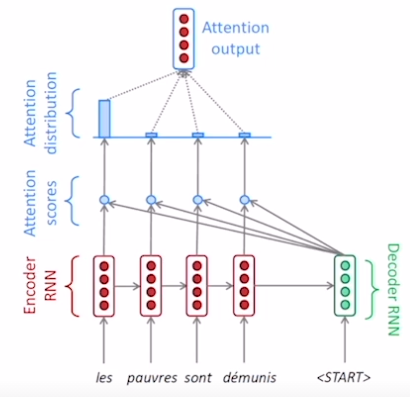

* decoder hidden-state vector와 context vector가 concat이 되어 output layer의 input으로 들어감
  * 이로부터 다음에 나올 단어를 예측함
* <EOS> token이 나올 때까지 수행함
* decoder hidden-state vector의 역할
  * output layer의 input으로 사용됨
  * attention 가중치를 결정함

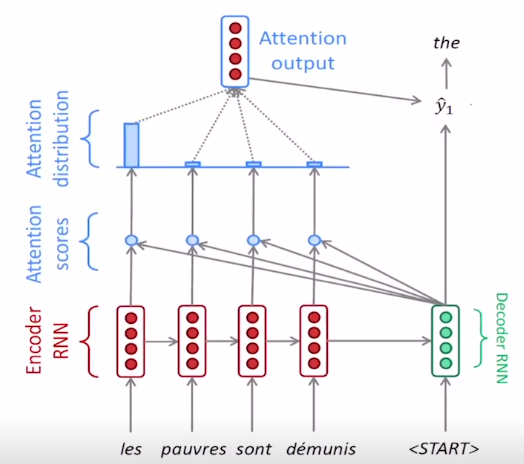

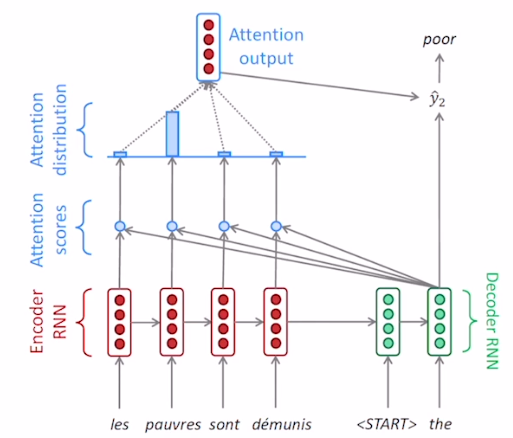

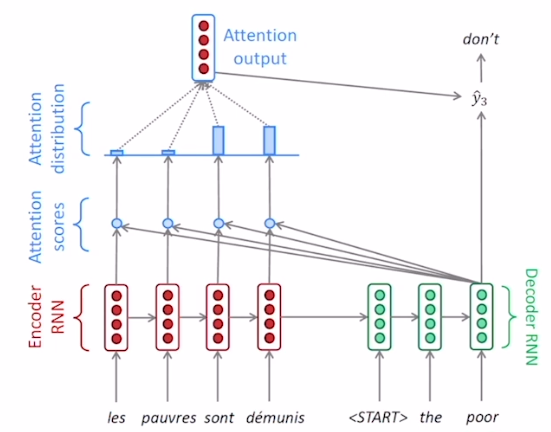

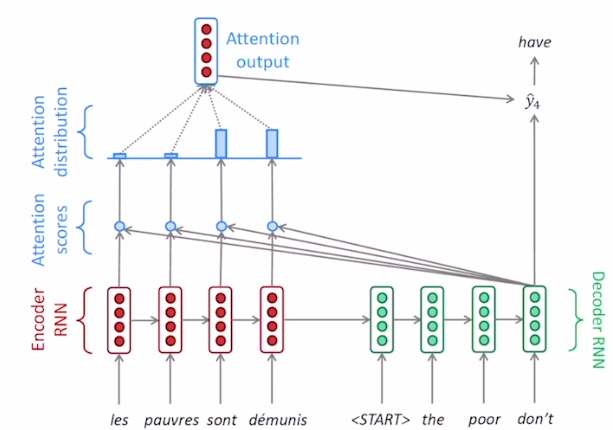

* Teacher forcing
  * ground truth를 매 timestep 마다 input으로 주어서, 이상한 단어를 예측하더라도 이후 단어 예측에 영향을 끼치지 않음
  * 학습이 좀더 빠르고 용이함
  * test time에서 model을 사용하는 환경, 상황과는 달라 괴리를 가짐
* 학습 초반에 teacher forcing을 사용하여 model의 예측이 좀 더 정확해졌을 때, teacher forcing을 사용하지 않고, 실제 예측한 값을 다음 timestep의 input으로 넣어주어 학습하는 방법이 있음

### Different Attention mechanism
* 특정 decoder의 hidden-state vector를 가지고 encoder의 hidden-state vector와의 유사도를 구하는 방식의 확장/변형
 * attention score를 구하는 3가지 방식
$$\mathrm{score}(h_t, \bar{h}_s) = \begin{cases} h_t^\intercal \bar{h}_s & dot \\ h_t^\intercal W_a \bar{h}_s & general \\ v_a^\intercal \tanh{(W_a [h_t ; \bar{h}_s])} & con \end{cases}$$
* $\mathrm{score}(h_t, \bar{h}_s)$ : 유사도
* $h_t$ : decoder의 hidden-state vector
* $\bar{h}_s$ : encoder에서 각 word 별로의 hidden-state vector
* $h_t^\intercal \bar{h}_s$ : 내적
* $h_t^\intercal W_a \bar{h}_s$ : generalized dot product
  * 각 dimension에 가중치 부여
* $v_a^\intercal \tanh{(W_a [h_t ; \bar{h}_s])}$ : concat 기반의 attention
  * $;$ : concat
  * $W_a [h_t ; \bar{h}_s]$ : 첫 번째 layer 선형 변환
    * $W_a$ : 첫 번째 layer
  * $\tanh{(W_a [h_t ; \bar{h}_s])}$ : non-linear unit 적용
  * $v_a^\intercal \tanh{(W_a [h_t ; \bar{h}_s])}$ : 두 번째 layer 선형 변환
    * $v_a^\intercal$ : 두 번째 layer
  * decoder hidden-state vector와 encoder의 하나의 hidden-state vector를 concat하고 fully-connected layer(multi-layer neural network / multi-layer perceptron) 의 input vector로 주어서 output으로 나오는 scalar값(유사도)을 구함
  * non-linear unit을 적용 후 layer를 더 쌓아서 해당 layer의 parameter와 선형변환에 의해서 최종적으로 scalar 값이 나오도록 하는 형태로 attention을 구성할 수 있음

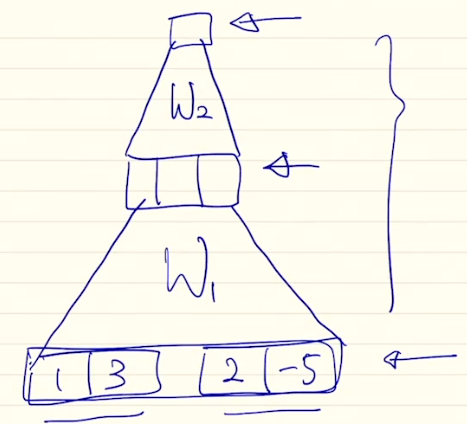

* Attention 의 장점과 특성
  * Seq2Seq model에 추가되면서 NMT(neural machine translation) 에서 성능을 많이 올려줌 
    * decoder의 매 timestep마다 입력 sequence에서의 어떤 부분에 집중해서 직접적으로 정보를 사용해서 예측에 활용할지를 가능하게 함
  * bottleneck problem을 해결함
    * bottleneck problem : encoder의 마지막 timestep에서의 hidden-state vector만을 사용하여 번역을 수행해야함, 긴 문장에서는 번역이 잘 되기 어려움
  * vanishing gradient problem을 도와줌
    * backpropagation을 하는 경우 decoder와 encoder의 많은 timestep을 거쳐야 하기 때문에 정보가 온전히 보전되지 않아 발생하는 long term dependency문제를 해결함
    * attention을 사용하여 timestep을 거치지 않고 attention module을 바로 통과하여 원하는 특정 timestep의 hidden-state vector까지 gradient를 빠르고 큰 변질 없이 전달해줄 수 있음
  * interpretability
    * 흥미로운 해석 가능성을 제공함
    * attention의 pattern이 어떤 식으로 나오는지를 조사하여, decoder가 각 단어를 예측할 때 encoder 상의 어떤 단어에 집중했는지를 알 수 있음
    * 언제 어떤 단어를 봐야할 지에 대한 alignment를 neural network 스스로 배우는 현상을 보여줌
      * 전반적인 과정들은 decoder에서 해당하는 예측 단어에 대한 ground truth를 통해 적용되는 softmax loss만으로 내부적인 attention module도 적절하게 학습이 되는 것을 알 수 있음

### Attention Examples in Machine Translation
* Seq2Seq with Attention이 machine translation에 적용되었을 때, attention distribution 또는 attention vector의 패턴을 시각화한 사례

* 왼쪽의 단어로 이루어진 문장이 위쪽 영어로 번역
  * 왼쪽 : encoder input
  * 위쪽 : decoder output
  * 입력 단어에 대한 attention을 보여줌
  * 각 언어에 대한 문장구조에 따라 attention pattern이 달라질 수 있음

* 역순으로 단어를 예측할 수 있음

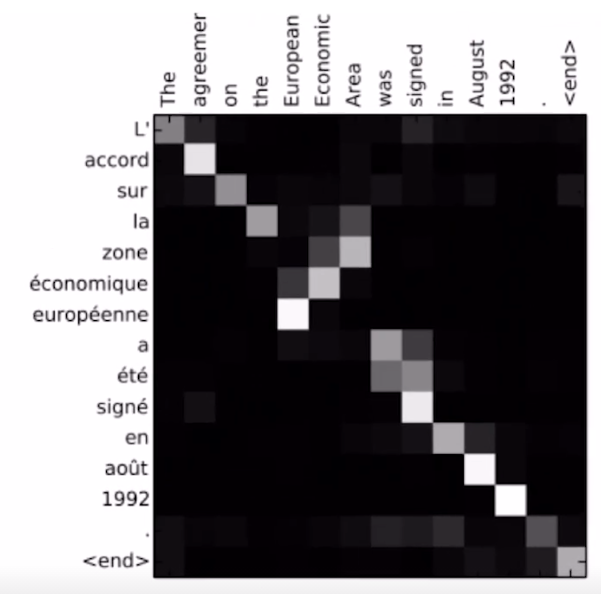

* 한 단어를 바라볼 때 여러 개의 input 단어를 볼 수도 있음

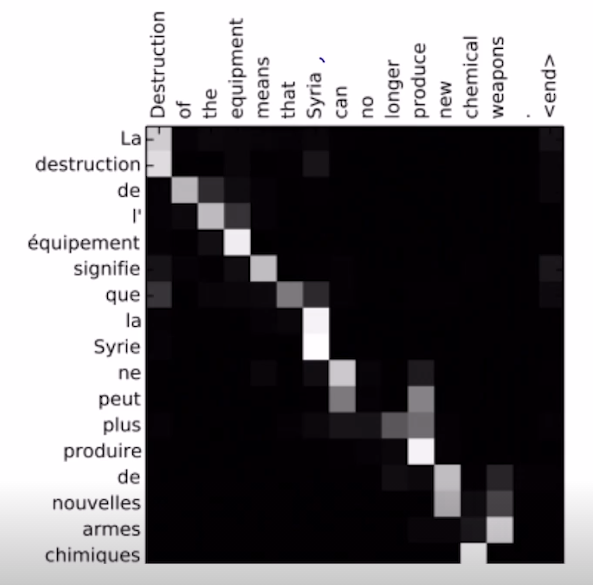